In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import timeit

# from importlib import reload
# import feature_extraction
# reload(feature_extraction)
from biomarkers import (
    EEG,
    EMG,
    BP,
    EOG,
    ECG,
    TREV,
    GSR,
    Resp,
    EGG,
    MARKER_TO_CHANNEL_NAMES,
)
from feature_extraction import (
    Feature,
    EEG_BANDS,
    STAT_FEATURES,
)
from data_utils import (
    extract_labels,
    load_data_from_dir,
    get_all_behaviors_labels,
    extract_features_by_channel,
)
from calculate_correlation import (
    EEG_BANDS_LIST,
    get_all_behaviors_feature_to_pc_by_markers,
    get_all_trials_average_rp_values,
)


In [3]:
subject_list = [2001] #, 2017, 2026, 2028, 2033,  2037, 2041
subj_to_data = {}
data_dir = '../CleandDataV2/'
for subj in subject_list:
    dir_name = data_dir + str(subj)
    all_data = load_data_from_dir(dir_name)
    subj_to_data[subj] = all_data

Loading ../CleandDataV2/2001 data...


In [20]:
import mne
from biomarkers import (
    EEG_CHANEL_NAMES,
    EEG_NUM_CHANNELS,
    EEG_MONTAGES,
)
from constants import AUDIO_BLOCKS

all_data = []
data = subj_to_data[2001]
for b in AUDIO_BLOCKS[:1]:
    b_data = data[b].get_all_data()['EEG']
    for t in range(b_data.shape[-1]):  # (channel, time, trial)
        all_data.append(b_data[65:65+2, :, t])       

all_data = np.array(all_data)
all_data.shape # (epochs, channel, samples)

(13, 2, 12288)

In [21]:
sampling_freq = 512  # in Hertz
info = mne.create_info(
    ch_names=['C1', 'C2'], #EEG_CHANEL_NAMES,
    sfreq=sampling_freq,
    ch_types=["eeg"] * 2, #EEG_NUM_CHANNELS,
)
info.set_montage(EEG_MONTAGES)

simulated_epochs = mne.EpochsArray(all_data, info)
#simulated_epochs.plot(picks="eeg", show_scrollbars=False, events=False)

Not setting metadata
13 matching events found
No baseline correction applied
0 projection items activated


In [22]:
from matplotlib.colors import TwoSlopeNorm
from mne.time_frequency import tfr_multitaper

freqs = np.arange(2, 36)  # frequencies from 2-35Hz
vmin, vmax = -1, 1.5  # set min and max ERDS values in plot
baseline = (0, 1)  # baseline interval (in s)
cnorm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)  # min, center & max ERDS

kwargs = dict(
    n_permutations=100, step_down_p=0.05, seed=1, buffer_size=None, out_type="mask"
)  # for cluster test

tfr = tfr_multitaper(
    simulated_epochs,
    freqs=freqs,
    n_cycles=freqs,
    use_fft=True,
    return_itc=False,
    average=False,
    decim=2,
)

tmin, tmax = 0, 24
tfr.crop(tmin, tmax).apply_baseline(baseline, mode="percent")

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


Not setting metadata
Applying baseline correction (mode: percent)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s finished
/var/folders/6y/khb9drcn0p373bwf72szrzvm0000gn/T/ipykernel_77096/3707237129.py:24: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.time_frequency.tfr.EpochsTFR'>.tmax (23.9961 s)
  tfr.crop(tmin, tmax).apply_baseline(baseline, mode="percent")


<EpochsTFR | time : [0.000000, 23.996094], freq : [2.000000, 35.000000], epochs : 13, channels : 2, ~41.4 MB>

In [23]:
df = tfr.to_data_frame(time_format=None)
df.head()

,time,freq,epoch,condition,C1,C2
0,0.000000,2.0,0,1,-0.245599,0.097460
1,0.003906,2.0,0,1,-0.236825,0.101314
2,0.007812,2.0,0,1,-0.232266,0.105365
3,0.011719,2.0,0,1,-0.230512,0.109759
4,0.015625,2.0,0,1,-0.227852,0.113190


In [54]:
import seaborn as sns

df = tfr.to_data_frame(time_format=None, long_format=True)

# Map to frequency bands:
freq_bounds = {"_": 0, "delta": 4, "theta": 8, "alpha": 12, "beta1": 20, "beta2": 30, "gamma": 50}
df["band"] = pd.cut(
    df["freq"], list(freq_bounds.values()), labels=list(freq_bounds)[1:]
)

# Filter to retain only relevant frequency bands:
freq_bands_of_interest = ["delta", "theta", "alpha", "beta1", "beta2", "gamma"]
df = df[df.band.isin(freq_bands_of_interest)]
df["band"] = df["band"].cat.remove_unused_categories()

# Order channels for plotting:
df["channel"] = df["channel"].cat.reorder_categories(("C1", "C2"), ordered=True)

Converting "condition" to "category"...
Converting "epoch" to "category"...
Converting "channel" to "category"...
Converting "ch_type" to "category"...


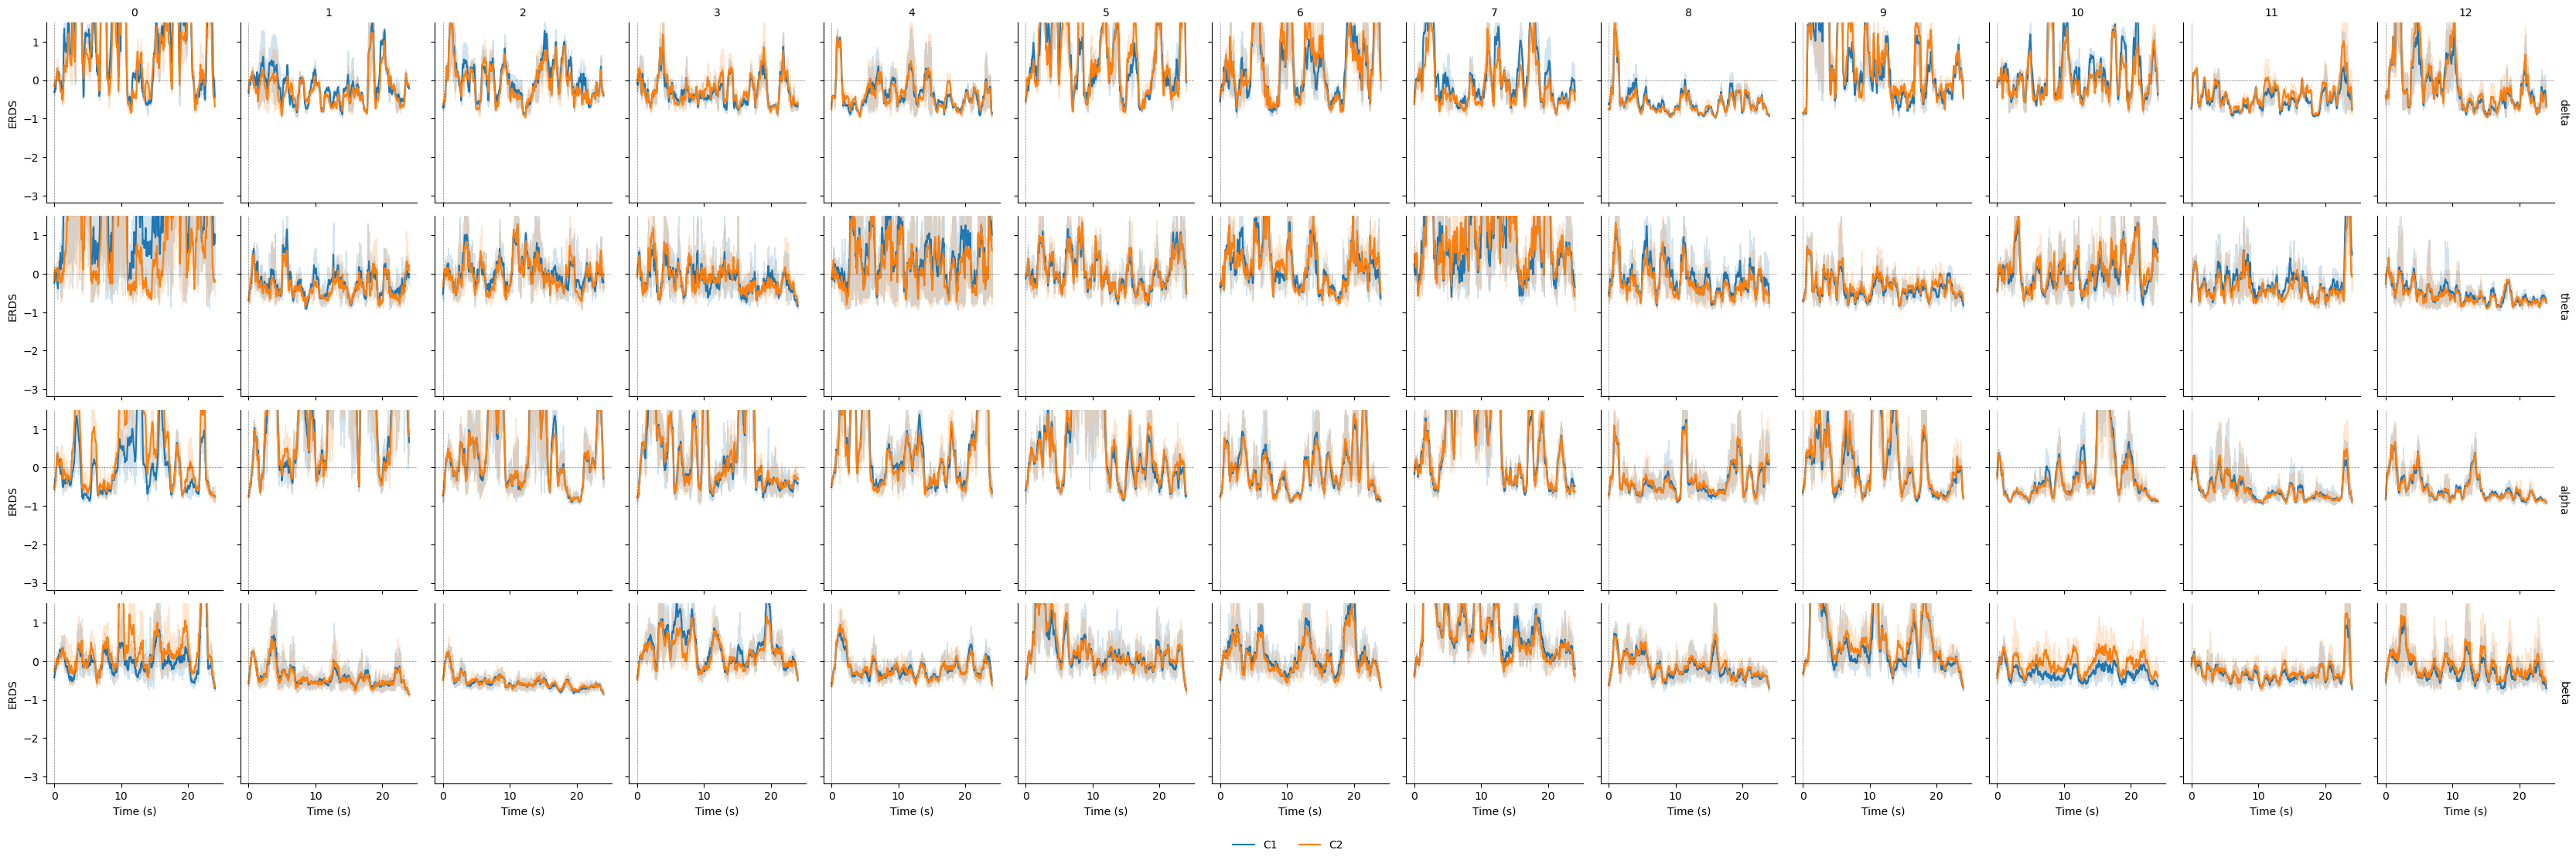

In [53]:
g = sns.FacetGrid(df, row="band", col="epoch", margin_titles=True)
g.map(sns.lineplot, "time", "value", "channel", n_boot=1)
axline_kw = dict(color="black", linestyle="dashed", linewidth=0.5, alpha=0.5)
g.map(plt.axhline, y=0, **axline_kw)
g.map(plt.axvline, x=0, **axline_kw)
g.set(ylim=(None, 1.5))
g.set_axis_labels("Time (s)", "ERDS")
g.set_titles(col_template="{col_name}", row_template="{row_name}")
g.add_legend(ncol=2, loc="lower center")
g.fig.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.08)

### Load Features from CSV

In [ ]:
from dataframe.csv_utils import (
    load_data_from_csv,
    get_labels_from_result,
    get_features_from_result,
)

dir_name = "eeg_features2"
result = load_data_from_csv(dir_name)
all_label_array, label_list = get_labels_from_result(result)
all_feature_array, feature_names = get_features_from_result(result)
all_feature_array = all_feature_array.drop(["index"], axis=1)
feature_names = all_feature_array.columns
print(all_feature_array.shape, len(feature_names), len(label_list))


### Load raw data 

In [ ]:
import os

relative_data_dir = '../CleandDataV2/'
feature_dir = 'eeg_features2'

extracted_subj = list(map(lambda s: s.rstrip('_features.csv'), os.listdir(feature_dir)))
subject_iterator = filter(lambda x: (x.isnumeric() and x not in extracted_subj), os.listdir(relative_data_dir))
all_dirs = list(map(lambda s: relative_data_dir + s, subject_iterator))
all_dirs.sort()

len(all_dirs)

 Extract features from physiological signals

In [ ]:
from dataframe.extraction import (
    extract_features_by_markers,
)

# (TODO) GSR, Resp, TREV  BP.__name__, EGG.__name__
markers = [EEG.__name__]
dir_to_data = {}
for dir_name in all_dirs:
    all_data = load_data_from_dir(dir_name)
    dir_to_data[dir_name] = all_data
    list_dir = [dir_name]

    starttime = timeit.default_timer()
    # extract features
    df = extract_features_by_markers(markers, dir_to_data, list_dir)
    #     print(s, df.shape)
    #     subject_features = result[result["Subject"] == s]
    #     subject_features = subject_features.reset_index()

    print("The time difference is :", timeit.default_timer() - starttime)
    all_features = df  # pd.concat([df, subject_features], axis=1)
    # save features to csv
    subject_name = dir_name.replace(relative_data_dir, "")
    """ 
      extract labels from behavior data
    """
    all_label_array = extract_labels(dir_to_data, all_dir=list_dir)
    for l, value in all_label_array.items():
      all_features[l.capitalize()] = value

    all_features["Subject"] = [subject_name] * 130
    all_features.to_csv(f"eeg_features2/{subject_name}_features.csv", index=False)

In [ ]:
for k in dir_to_data['../CleandDataV2/2046'].keys():
    print(dir_to_data['../CleandDataV2/2046'][k].get_all_data()['EEG'].shape, k)

In [ ]:
import plotly.express as px

def get_umap(result: pd.DataFrame):
    from umap import UMAP
    features = result.drop('condition', axis=1)
    
    # Run UMAP
    umap2d = UMAP(n_components=2, init="random", random_state=0)
    proj_2d = pd.DataFrame(umap2d.fit_transform(features))

    # Concatanate the umap points and original data
    proj_2d.columns = ["C1_2d", "C2_2d"]
    result = result.reset_index()
    return pd.concat([result, proj_2d], axis=1, join="inner")

def get_conditions(condition: str, mode: str):
    if mode == 'v':
        if 'hv' in condition:
            return 'h_valence'
        elif 'nv' in condition:
            return 'n_valence'
    elif mode == 'a':
        if 'ha' in condition:
            return 'h_arousal'
        elif 'la' in condition:
            return 'l_arousal'
    else:
        if 'breath' in condition:
            return 'breath'
        elif 'audio' in condition:
            return 'audio'
    return condition
        

    
all_df = pd.DataFrame()
marker = 'EMG'
for condition, markers in all_data.items():
    df = pd.DataFrame(data=np.swapaxes(markers.get_all_data()[marker][0], 0, 1))
    condition = get_conditions(condition, 'v')       
    df['condition'] = [condition]*data[2].shape[1]
    all_df = pd.concat([all_df, df], axis=0)

plotX = get_umap(all_df)

fig = px.scatter(
    plotX,
    x="C1_2d",
    y="C2_2d",
    color="condition",
)
fig.update_layout(
    title_text=f'Subject 2024 {marker}'
)
fig.show()

In [ ]:
"""
    calculate correlation
"""
from dataframe.correlation import (
    get_feature_to_corr_by_behavior,
    get_behavior_to_average_corr,
)

marker = EEG.__name__
behavior_to_rp = {}
for b in ["Valence", "Arousal", "Attention"]:
    behavior_to_rp[b] = get_feature_to_corr_by_behavior(
        result, b, feature_names, marker, "pearsonr"
    )

avg_condition_to_features = get_behavior_to_average_corr(behavior_to_rp)


In [ ]:
from plotting import (
    plot_correlation_table_by_channel,
    plot_k_chaneels_by_r_value,
    plot_eeg_topomap_all_blocks,
    plot_time_series_by_epoch,
)

""" plot the single channel correlation table
"""
# channel = 1
# features = STAT_FEATURES
# channel_names = MARKER_TO_CHANNEL_NAMES[marker]
# for condition, feature_to_pc in avg_condition_to_features.items():
#     label = f"{channel_names[channel]} {condition}"
#     plot_correlation_table_by_channel(
#         label,
#         feature_to_pc,
#         ["pearson r", "pearson p", "spearman r", "spearman p"],
#         features,
#         channel,
#         True,
#     )

""" plot the top channel correlation table given r values
"""
# for condition, feature_to_pc in avg_condition_to_features.items():
#     features = feature_to_pc.keys()
#     plot_k_chaneels_by_r_value(feature_to_pc, channel_names, features, condition, True, 10)
#     plot_k_chaneels_by_r_value(feature_to_pc, channel_names, features, condition, False, 10)

""" 
    plot the topography for eeg
"""
# for condition, feature_to_pc in avg_condition_to_features.items():
#     plot_eeg_topomap_all_blocks(condition, feature_to_pc)
#     features = feature_to_pc.keys()
#     for f in features:
#         plot_eeg_topomap_one_block(condition, f, feature_to_pc, all_block_names)


""" plot the top channel correlation table with different blocks
"""
# all_block_names = list(all_data.keys())
# all_block_names.sort()
# for condition, feature_to_pc in avg_condition_to_features.items():
#     plot_eeg_pearson_correlation_table(condition, feature_to_pc, all_block_names, 1)

""" plot the series for the top k channels
"""
# define number of rows and columns for subplots
# nrow = 3
# ncol = 2
# for condition, feature_to_pc in avg_condition_to_features.items():
#     print(f"{condition}")
#     ser_list = get_eeg_pearson_correlation_series_all_blocks(feature_to_pc, channel_names, k=20)
#     plot_series(nrow, ncol, ser_list)


""" 
    plot the time series given the marker and block
"""
# plot_time_series_by_epoch(all_data['audio_hvla'], 'EEG', 'audio_hvla', 0)

""" 
    plot the scattor for physiological signals
"""
# plot_pd_scatter_by_marker("LEOG", result, ['../2007', '../2002', '../2006'])


In [ ]:
""" 
    discard high correlated features
"""
corr = all_feature_array.corr()
updated = corr[(((corr < 0.9) & (corr > -0.9)) | (corr == 1)).all(axis=1)]
all_feature_array = all_feature_array[list(updated.index.values)]
feature_names = all_feature_array.columns

print(all_feature_array.shape, len(feature_names), len(label_list))


In [ ]:
import seaborn as sns

"""
    plot the correlation heatmap
"""
corr = all_feature_array.corr()
sorted_corr = corr.sort_index().sort_index(axis=1)
truncated_corr = sorted_corr.truncate(
    before="D7_ALPHA", after="VEOG_VAR", axis="rows"
).truncate(before="D7_ALPHA", after="VEOG_VAR", axis="columns")

plt.figure(figsize=(14, 12))
sns.heatmap(truncated_corr, vmin=-1, vmax=1, annot=False, cmap="RdBu_r")


In [ ]:
features = STAT_FEATURES
marker = EOG.__name__

channel_names = dir_to_data["../2002"]["audio_hvla"].get_chanlocs(marker)
channel_num = 0
""" 
    extract features from physiological signals
"""
# features_to_trials = extract_features_by_channel(marker, dir_to_data, features, channel_num, channel_names[channel_num])
# dir_name_to_labels = {}
# for dir_name, all_data in dir_to_data.items():
#     dir_name_to_labels[dir_name] = get_all_behaviors_labels(all_data)


In [ ]:
""" 
    extract correlation from physiological signals
"""
num_channels = 4
num_blocks = 0
dir_name_to_ctf = {}
for dir_name, all_data in dir_to_data.items():
    dir_name_to_ctf[dir_name] = get_all_behaviors_feature_to_pc_by_markers(
        all_data, marker, features, num_channels, num_blocks
    )

avg_condition_to_features = get_all_trials_average_rp_values(
    dir_name_to_ctf, features, "pearson"
)
spearman_corr = get_all_trials_average_rp_values(dir_name_to_ctf, features, "spearman")
for b, feature_to_pc in avg_condition_to_features.items():
    for f, pc in feature_to_pc.items():
        avg_condition_to_features[b][f] = np.hstack((pc, spearman_corr[b][f]))